In [1]:
# Basic imports

import sys

import numpy as np

import xarray as xr

import matplotlib.pyplot as plt

from IPython.display import HTML

import datetime
from cftime import num2date

import cmocean  # for nice oceanographic colourmaps

#JUPYTER notebook magics
%matplotlib inline 

In [2]:
%%bash

# We tune the model and forcing using these modules
/home/nextsimdg/build/nextsim --help-config WintonAlbedo
/home/nextsimdg/build/nextsim --help-config FluxConfiguredOcean
/home/nextsimdg/build/nextsim --help-config ThermoWinton

WintonAlbedo

WintonAlbedo.iceAlbedo
numeric    range: 0—1  (default = 0.65)
Albedo of snow-free ice.

WintonAlbedo.snowAlbedo
numeric    range: 0—1  (default = 0.8)
Albedo of dry snow.

WintonAlbedo.meltAlbedo
numeric    range: 0—1  (default = 0.75)
Albedo of melting snow.


FluxConfiguredOcean

FluxConfiguredOcean.qio
numeric    range: -∞—∞  (default = 0)
Ocean to ice heat flux (W m⁻²).

FluxConfiguredOcean.sst
numeric    range: -273—374  (default = -1.5)
Sea surface temperature (˚C).

FluxConfiguredOcean.sss
numeric    range: 0—1000  (default = 32)
Sea surface salinity (PSU).

FluxConfiguredOcean.mld
numeric    range: 0—10984  (default = 10)
Mixed layer depth (m).

FluxConfiguredOcean.current_u
numeric    range: -∞—∞  (default = 0)
Ocean current in the x (eastward) direction (m s⁻¹).

FluxConfiguredOcean.current_v
numeric    range: -∞—∞  (default = 0)
Ocean current in the y (northward) direction (m s⁻¹).


ThermoWinton

nextsim_thermo.ks
numeric    range: 0—∞ W K⁻¹ m⁻¹ (default = 0.

In [3]:
# Create initial conditions using the make_init_base.py class found in nextsimdg/run

sys.path.append('../../nextsimdg/run')

from make_init_base import initMaker

# Single column. Resolution doesn't matter, because we're not using the dynamics
nfirst = 1
nsecond = 1
nLayers = 3
resolution = 50

# Initialise the object
initializer = initMaker("init_column.nc", nfirst, nsecond, nLayers, resolution)

ice_salinity = 5.  # should match Ice::s in constants.hpp
mu = -0.055  # should match Water::mu in constants.hpp
ocean_temperature = -1.54
ocean_salinity = ocean_temperature / mu

# Set all the basic variables
initializer.mask[:, :] = 1
initializer.cice[:, :] = 1.
initializer.hice[:, :] = 2.
initializer.hsnow[:, :] = 0.3
initializer.sss[:, :] = ocean_salinity
initializer.sst[:, :] = ocean_temperature
initializer.tice[:, :, :] = ice_salinity * mu

"""
In a normal script, the file is written when initializer goes out of scope - but in 
Jupyter, we need to call __writeFile__ explicitly
"""
initializer.__writeFile__()

Producing file init_column.nc


In [4]:
%%bash

# Run the model with the config file for a single column setup
time /home/nextsimdg/build/nextsim --config-file config_files/config_column.cfg

ParaGridIO::closeAllFiles: closing 1 files



real	0m6.760s
user	0m5.159s
sys	0m0.075s


In [5]:
# Load the NetCDF file
ds = xr.open_dataset("thermo.diagnostic.nc", group="/data")
print(ds)

<xarray.Dataset>
Dimensions:       (time: 365, yvertex: 2, xvertex: 2, ncoords: 2, ydim: 1,
                   xdim: 1, dg_comp: 6, zdim: 3)
Coordinates:
  * time          (time) float64 1.262e+09 1.262e+09 ... 1.294e+09 1.294e+09
Dimensions without coordinates: yvertex, xvertex, ncoords, ydim, xdim, dg_comp,
                                zdim
Data variables:
    coords        (yvertex, xvertex, ncoords) float64 ...
    grid_azimuth  (time, ydim, xdim) float64 ...
    hice          (time, ydim, xdim, dg_comp) float64 ...
    hsnow         (time, ydim, xdim) float64 ...
    tice          (time, zdim, ydim, xdim) float64 ...
    x             (time, ydim, xdim) float64 ...
    y             (time, ydim, xdim) float64 ...


In [6]:
# Create sensible dates to use
time = ds['time']
time_vals = num2date(time.values, units='seconds since 1970-01-01', calendar='gregorian')
time_index = 23

In [7]:
# Calculate ice draught for a nicer visualisation
rho = 917
rhoSnow = 330
rhoOcean = 1025

# Throw away unneeded data and dimensions
hice = np.squeeze(ds['hice'].isel(dg_comp=0))
hsnow = np.squeeze(ds['hsnow'])
tice = np.squeeze(ds['tice'])

iceDraught = (hice * rho + hsnow * rhoSnow) / rhoOcean

In [8]:
# Some simple diagnostics
print('hice  max: {0:0.2f}, min: {1:0.2f}, mean: {2:0.2f}'.format(hice.max(), hice.min(), hice.mean()))
print('hsnow max: {0:0.2f}, min: {1:0.2f}, mean: {2:0.2f}'.format(hsnow.max(), hsnow.min(), hsnow.mean()))

hice  max: 2.84, min: 2.43, mean: 2.59
hsnow max: 0.40, min: 0.00, mean: 0.24


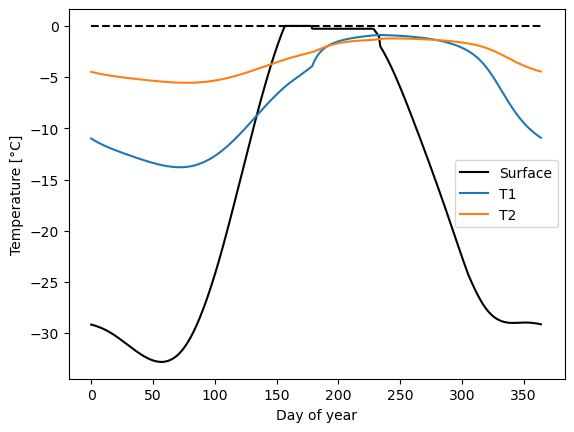

In [9]:
# Figure showing temperature evolution, cf,. Winton (2000) figure 2
plt.figure()
plt.plot([0, len(ds['hice'])], [0, 0], 'k--')
plt.plot(tice[:, 0], 'k', label="Surface")
plt.plot(tice[:, 1], label="T1")
plt.plot(tice[:, 2], label="T2")
plt.xlabel("Day of year")
plt.ylabel("Temperature [°C]")
plt.legend()
plt.show()

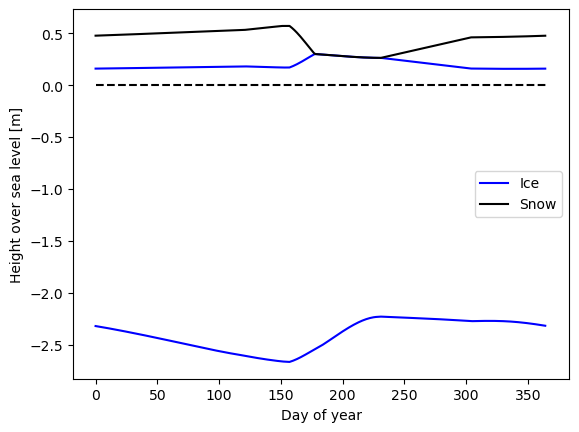

In [10]:
# Figure showing thickness evolution, cf. Winton (2000) figure 2
plt.figure()
plt.plot([0, len(hice)], [0, 0], 'k--')
plt.plot(hice - iceDraught, 'b', label="Ice")
plt.plot(hice + hsnow - iceDraught, 'k', label="Snow")
plt.plot(-iceDraught, 'b')
plt.xlabel("Day of year")
plt.ylabel("Height over sea level [m]")
plt.legend()
plt.show()

In [11]:
ds.close()